# Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import matplotlib.pyplot as plt, gc, os

GPU = True
try:
    import cupy, cudf
except ImportError:
    GPU = False

# if GPU:
#     print('RAPIDS version',cudf.__version__)
# else:
#     print("Disabling cudf, using pandas instead")
cudf = pd

In [2]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1
FEATURE_VER = 111

# RANDOM SEED
SEED = 108+5*VER+100*FEATURE_VER

# FOLDS PER MODEL
FOLDS = 5

# NOTEBOOK PATH
FEATURE_PATH = './'

DO_SUBMIT = False

print("VER:", VER)
print("fVER:", FEATURE_VER)

VER: 1
fVER: 111


# Load Data
Feature engineering is all done in: https://www.kaggle.com/code/roberthatch/amex-feature-engg-gpu-or-cpu-process-in-chunks

In [3]:
def do_miss_nan(df):
    # Impute missing values
#     df.fillna(value=-1, inplace=True)
    # Replace inf with zeros 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Reduce memory
    for c in df.columns:
      if c in get_not_used(): continue
      if str( df[c].dtype )=='int64':
          df[c] = df[c].astype('int32')
      if str(df[c].dtype )=='float64':
          df[c] = df[c].astype('float32')
    return df
def get_not_used():  
  return ['row_id', 'customer_ID', 'target', 'cid', 'S_2','D_103','D_139']    

# train = do_miss_nan(train)
# test = do_miss_nan(test)

In [4]:
print('Reading train data...')
TRAIN_PATH = f'{FEATURE_PATH}train_fe_v1.pickle'
train = pd.read_pickle(TRAIN_PATH)
print(train.shape)
train = do_miss_nan(train)
train = train.sample(frac=1, random_state=SEED)
train = train.reset_index(drop=True)
train.head()

Reading train data...
(458913, 2291)


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_143_min-max,D_144-mean,D_144-div-mean,D_144_min_div_max,D_144_min-max,D_145-mean,D_145-div-mean,D_145_min_div_max,D_145_min-max,target
0,836ab8c9b793c103f527c9921ae5cf298358301dcbf3a8...,2018-03-23,0.419922,0.0,0.059998,0.330078,0.000000,0.140015,0.000000,0.040009,...,0.0,-0.005386,0.000000,0.0,-0.010002,0.0,1.0,1.0,0.0,0
1,dc17e1cb25b4a6ba4edd43886ec9109db7815de4c2e747...,2018-03-14,0.879883,31.0,0.049988,1.009766,0.010002,-0.020004,0.000000,0.000000,...,0.0,-0.005386,0.000000,0.0,-0.010002,0.0,NaN,NaN,0.0,0
2,be6d78f47fefcc32b5d9968bad7aaf652d33ac48d527ce...,2018-03-18,0.919922,16.0,0.010002,0.819824,0.000000,0.180054,0.000000,0.010002,...,0.0,0.004616,1.857422,0.0,-0.010002,0.0,NaN,NaN,0.0,0
3,db6f04e450d7f754ff48a22fe780cd20a89d62c6a23853...,2018-03-17,0.529785,0.0,0.300049,0.070007,0.500000,0.250000,0.300049,0.540039,...,0.0,0.046143,4.332031,0.0,-0.070007,0.0,1.0,1.0,0.0,0
4,df335a6aa4d994a1c7008cde8bccb08ec49d942bb2cc97...,2018-03-02,0.859863,21.0,0.020004,1.009766,0.010002,0.090027,0.000000,0.000000,...,0.0,0.003078,1.444336,0.0,-0.010002,0.0,NaN,NaN,0.0,0


# Train XGB
We will train using `DeviceQuantileDMatrix`. This has a very small GPU memory footprint.

In [5]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)


# XGB MODEL PARAMETERS
BASE_LEARNING_RATE = 0.01
xgb_params = { 
    'max_depth': 7,
    'subsample':0.75,
    'colsample_bytree': 0.35,
    'gamma':1.5,
    'lambda':70,
    'min_child_weight':8,

    'objective':'binary:logistic',
    'eval_metric':['logloss', 'auc'],  ## Early stopping is based on the last metric listed.
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED,

    'num_parallel_tree':1
}

XGB Version 1.6.1


In [6]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [7]:
## TODO, replace with newer version.

# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    print("  4%  :", top_four)
    print("  Gini:", gini[1]/gini[0])
    print("Kaggle:", 0.5 * (gini[1]/gini[0] + top_four))
    return 0.5 * (gini[1]/gini[0] + top_four)

In [11]:
importances = []
PYRAMID_W = [0.5, 2/3, 0.75, 0.875, 1, 0]

def run_training(train, features):
    oof = []

    skf = KFold(n_splits=FOLDS)
    for fold,(train_idx, valid_idx) in enumerate(skf.split(
                train, train.target )):
        print('#'*25)
        print('### Fold',fold+1)
    
        # TRAIN, VALID, TEST FOR FOLD K
#         Xy_train = IterLoadForDMatrix(train.loc[train_idx], features, 'target')
        X_train = train.loc[train_idx, features]
        y_train = train.loc[train_idx, 'target']
        
        X_valid = train.loc[valid_idx, features]
        y_valid = train.loc[valid_idx, 'target']

        print('### Train size',len(train_idx),'Valid size',len(valid_idx),'Valid positives',y_valid.sum())
        print(f'### Training with all of fold data...')
        print('#'*25)
        dtrain = xgb.DMatrix(data=X_train, label=y_train)

#         dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
        dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

        # TRAIN MODEL FOLD K
        # PYRAMID: Smoothly go from diverse forest of early trees into focused boosted trees correcting residuals.
        #   final layer must have w==0
        #   columns:    forest|boost|adj_eta|w
        pyramid_layers = [(100,  10,  1.56,  0.5),
                          ( 20,  50,  1.3,   2/3),
                          (  1,1000,  1.25,  0.75),
                          (  1,1000,  1.125, 0.875),
                          (  1,3000,  1.0,   1),
                          (  1,9000,  0.5,   0)]
        assert(PYRAMID_W == [layer[-1] for layer in pyramid_layers])
        for (layer, (n_trees, n_rounds, adj_learning, w)) in enumerate(pyramid_layers):
            ## Load the manual parameters from the pyramid layer
            xgb_params['num_parallel_tree'] = n_trees
            xgb_params['learning_rate'] = n_trees*adj_learning*BASE_LEARNING_RATE
            xgb_params['random_state'] += 1
            
            ## No early stopping except on final round. This is important since the weighting causes the model to go backwards for a time at the start of the next layer.
            early_stop = None
            if w == 0:
                early_stop = 300

            print("Learning Rate:", xgb_params['learning_rate'])
            model = xgb.train(xgb_params, 
                        dtrain=dtrain,
                        evals=[(dtrain,'train'),(dvalid,'valid')],
                        num_boost_round=n_rounds,
                        early_stopping_rounds=early_stop,
                        verbose_eval=100//n_trees)
            ## save model layer here
            
            model.save_model(f'XGB_v{VER}_fold{fold}_layer{layer}.xgb')
#             model = xgb.Booster()

#             model.load_model(f'XGB_v{VER}_fold{fold}_layer{layer}.xgb')

            ## predict to load the predictions on the next model layer
            ## Don't set base margin on final layer. w = 0 is used as an encoded way to skip this step.
            if (w != 0):
                ptrain = model.predict(dtrain, output_margin=True)
                pvalid = model.predict(dvalid, output_margin=True)

                ## reduce the impact of all model layers so far by w. This should be another way to reduce over-specialization, without the computational cost of DART
                if (w < 1.0):
                    ptrain = ptrain * w
                    pvalid = pvalid * w

                ## This set_base_margin on the DMatrix data is what informs the next layer of the prior training.
                ## See code example from official demos: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/boost_from_prediction.py
                dtrain.set_base_margin(ptrain)
                dvalid.set_base_margin(pvalid)

                plt.hist(pvalid, bins=100)
                plt.title(f'Layer {layer} OOF Predictions')
                plt.show()

                del model, ptrain, pvalid
                gc.collect()

        # GET FEATURE IMPORTANCE FOR FOLD K
        dd = model.get_score(importance_type='weight')
        df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
        importances.append(df)

        # INFER OOF FOLD K
        # Note: Not necessary with current implementation having final pyramid layer with num_parallel_tree == 1, but more robust to divide best_ntree_limit
        #   by num_parallel_tree. Oddly, iteration range is based only on num_boost_rounds, but best_ntree_limit is stored as num_boost_rounds * num_parallel_trees
        print("Best_ntree_limit:", model.best_ntree_limit//xgb_params['num_parallel_tree'])
        oof_preds = model.predict(dvalid, iteration_range=(0,model.best_ntree_limit//xgb_params['num_parallel_tree']))
        print('For this fold:')
        ## TODO: update metric. Fork this notebook to confirm the latest version of the numpy implementation from author is even faster and equally accurate.
        ## https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations
        amex_metric_mod(y_valid.values, oof_preds)
    
        # SAVE OOF
        df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
        df['oof_pred'] = oof_preds
        oof.append( df )

        del X_train, y_train, dd, df
        del X_valid, y_valid, dvalid, model
        gc.collect()

    print('#'*25)
    print('OVERALL CV:')
    oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
    amex_metric_mod(oof.target.values, oof.oof_pred.values)
    return oof


In [9]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_143_min-max,D_144-mean,D_144-div-mean,D_144_min_div_max,D_144_min-max,D_145-mean,D_145-div-mean,D_145_min_div_max,D_145_min-max,target
0,836ab8c9b793c103f527c9921ae5cf298358301dcbf3a8...,2018-03-23,0.419922,0.0,0.059998,0.330078,0.000000,0.140015,0.000000,0.040009,...,0.0,-0.005386,0.000000,0.0,-0.010002,0.0,1.0,1.0,0.0,0
1,dc17e1cb25b4a6ba4edd43886ec9109db7815de4c2e747...,2018-03-14,0.879883,31.0,0.049988,1.009766,0.010002,-0.020004,0.000000,0.000000,...,0.0,-0.005386,0.000000,0.0,-0.010002,0.0,NaN,NaN,0.0,0
2,be6d78f47fefcc32b5d9968bad7aaf652d33ac48d527ce...,2018-03-18,0.919922,16.0,0.010002,0.819824,0.000000,0.180054,0.000000,0.010002,...,0.0,0.004616,1.857422,0.0,-0.010002,0.0,NaN,NaN,0.0,0
3,db6f04e450d7f754ff48a22fe780cd20a89d62c6a23853...,2018-03-17,0.529785,0.0,0.300049,0.070007,0.500000,0.250000,0.300049,0.540039,...,0.0,0.046143,4.332031,0.0,-0.070007,0.0,1.0,1.0,0.0,0
4,df335a6aa4d994a1c7008cde8bccb08ec49d942bb2cc97...,2018-03-02,0.859863,21.0,0.020004,1.009766,0.010002,0.090027,0.000000,0.000000,...,0.0,0.003078,1.444336,0.0,-0.010002,0.0,NaN,NaN,0.0,0


There are 2278 features!
(458913, 2291)
#########################
### Fold 1
### Train size 367130 Valid size 91783 Valid positives 23724
### Training with all of fold data...
#########################
Learning Rate: 1.56


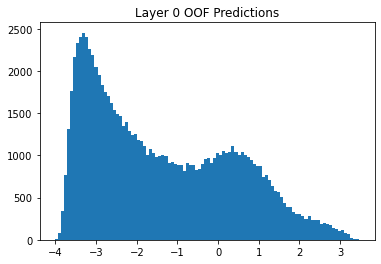

Learning Rate: 0.26


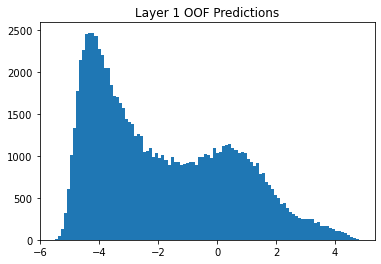

Learning Rate: 0.0125


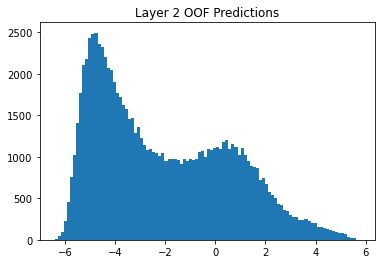

Learning Rate: 0.01125


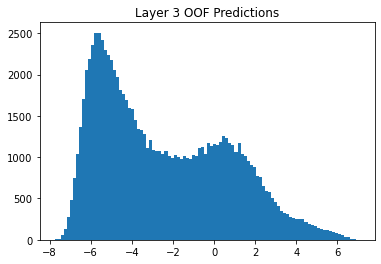

Learning Rate: 0.01


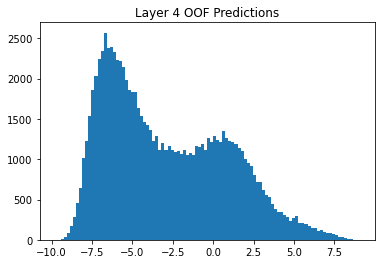

Learning Rate: 0.005
Best_ntree_limit: 2104
For this fold:
  4%  : 0.66569716
  Gini: 0.9254227643241941
Kaggle: 0.7955599608535796
#########################
### Fold 2
### Train size 367130 Valid size 91783 Valid positives 23895
### Training with all of fold data...
#########################
Learning Rate: 1.56


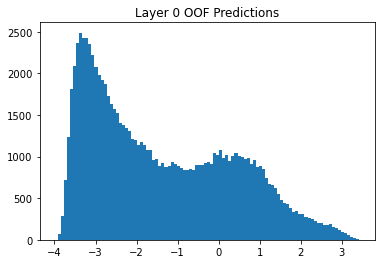

Learning Rate: 0.26


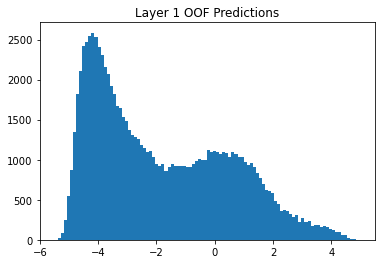

Learning Rate: 0.0125


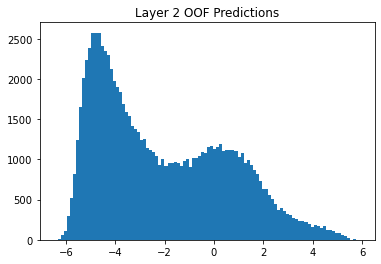

Learning Rate: 0.01125


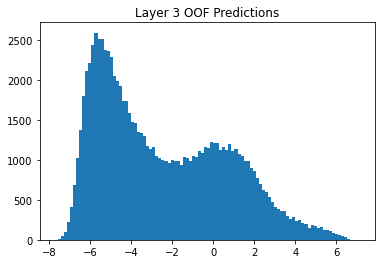

Learning Rate: 0.01


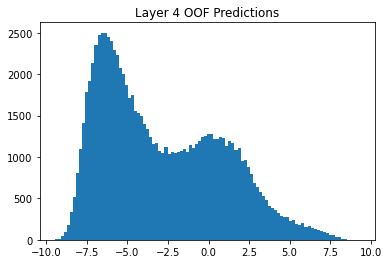

Learning Rate: 0.005
Best_ntree_limit: 3437
For this fold:
  4%  : 0.6676292
  Gini: 0.9251018745237929
Kaggle: 0.7963655284312537
#########################
### Fold 3
### Train size 367130 Valid size 91783 Valid positives 23812
### Training with all of fold data...
#########################
Learning Rate: 1.56


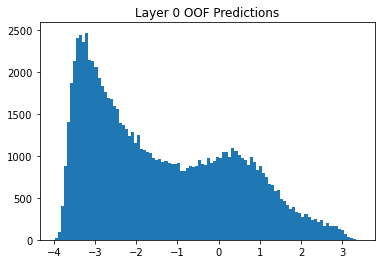

Learning Rate: 0.26


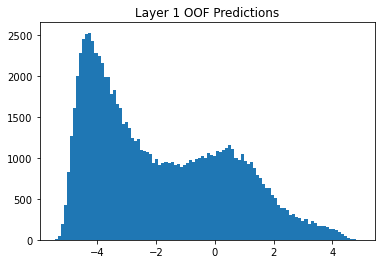

Learning Rate: 0.0125


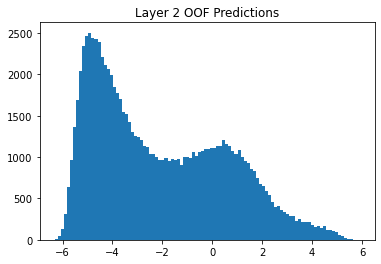

Learning Rate: 0.01125


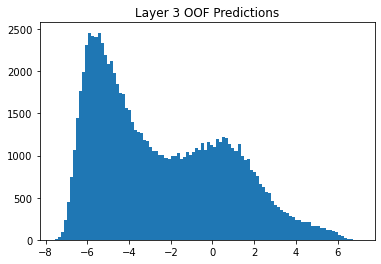

Learning Rate: 0.01


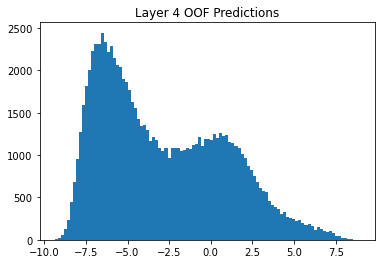

Learning Rate: 0.005
Best_ntree_limit: 1182
For this fold:
  4%  : 0.6738619
  Gini: 0.9272613186407944
Kaggle: 0.800561619737191
#########################
### Fold 4
### Train size 367131 Valid size 91782 Valid positives 23683
### Training with all of fold data...
#########################
Learning Rate: 1.56


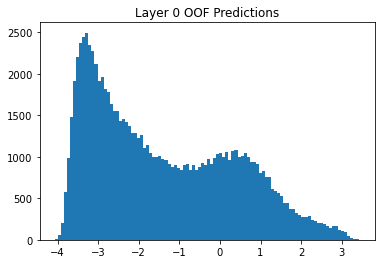

Learning Rate: 0.26


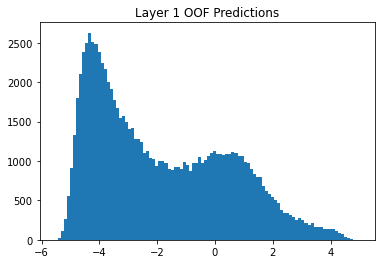

Learning Rate: 0.0125


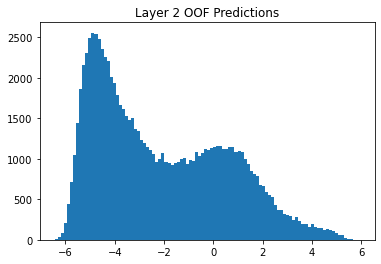

Learning Rate: 0.01125


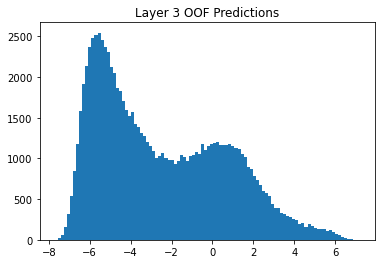

Learning Rate: 0.01


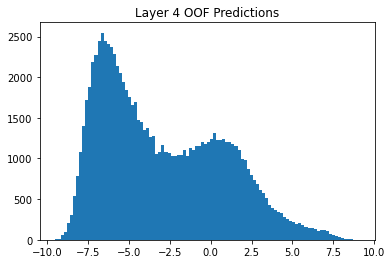

Learning Rate: 0.005
Best_ntree_limit: 1090
For this fold:
  4%  : 0.6712832
  Gini: 0.9244878872440999
Kaggle: 0.7978855363630626
#########################
### Fold 5
### Train size 367131 Valid size 91782 Valid positives 23714
### Training with all of fold data...
#########################
Learning Rate: 1.56


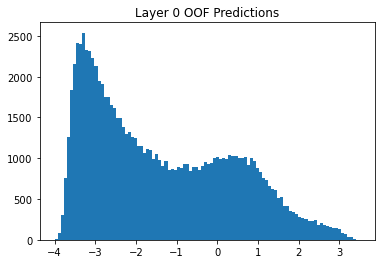

Learning Rate: 0.26


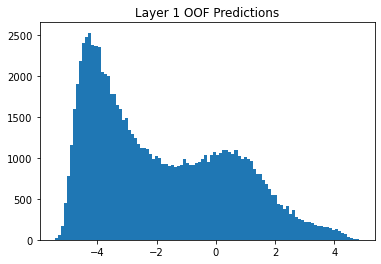

Learning Rate: 0.0125


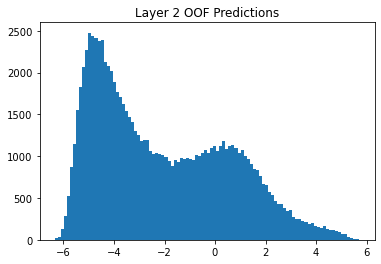

Learning Rate: 0.01125


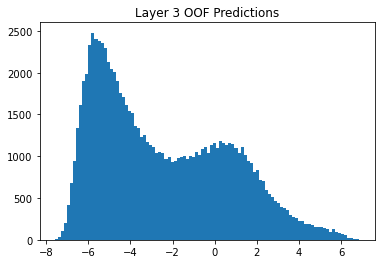

Learning Rate: 0.01


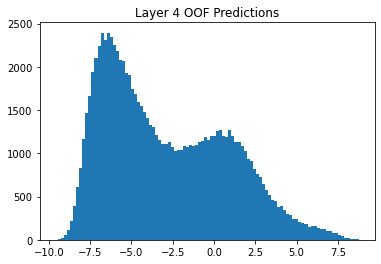

Learning Rate: 0.005
Best_ntree_limit: 886
For this fold:
  4%  : 0.67167073
  Gini: 0.927231896445324
Kaggle: 0.7994513156638394
#########################
OVERALL CV:
  4%  : 0.6696317
  Gini: 0.9258895132572242
Kaggle: 0.7977606164232288


In [14]:
features = [col for col in train.columns if col not in ['customer_ID', 'target','S_2']]
features = [col for col in features if 'B_29' not in col]
print(f'There are {len(features)} features!')
print(train.shape)

oof = run_training(train, features)

In [15]:
# CLEAN RAM
# del train
# _ = gc.collect()

# Save OOF Preds

In [19]:
oof_xgb = pd.read_pickle(TRAIN_PATH)[['customer_ID']].drop_duplicates()
oof_xgb = oof_xgb.set_index('customer_ID')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index()
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000254
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000998
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000628
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.005549
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.001256


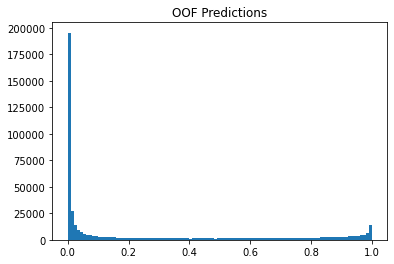

In [20]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [21]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [22]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

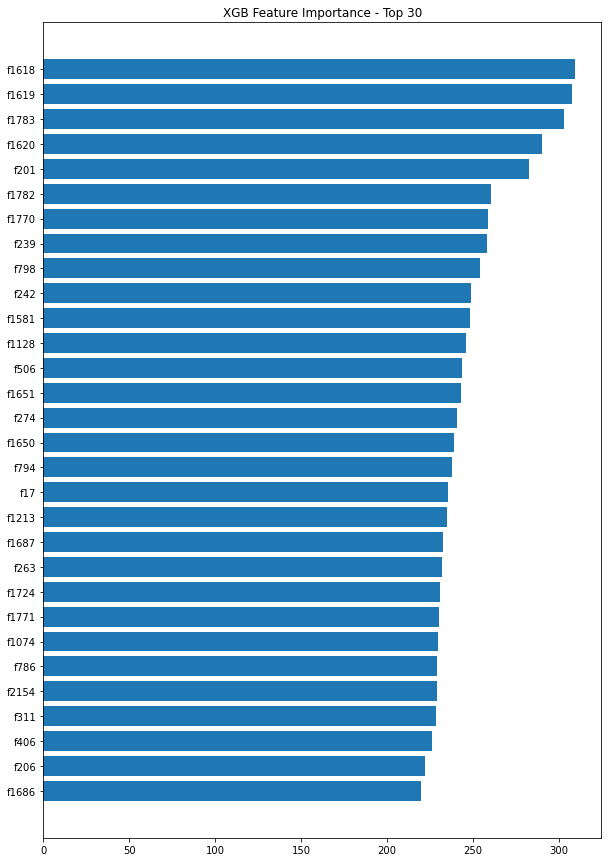

In [23]:
NUM_FEATURES = 30
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

del df, importances

# Infer Test

In [24]:
DO_SUBMIT = 1

In [25]:
if DO_SUBMIT:
    gc.collect()

    # INFER TEST DATA IN PARTS

    TEST_SECTIONS = 1
    TEST_SUB_SECTIONS = 1

    test_preds = []
    customers = False
    for k in range(TEST_SECTIONS):
        for i in range(TEST_SUB_SECTIONS):    
            # READ PART OF TEST DATA
            print(f'\nReading test data...')
            test = cudf.read_pickle(f'test_fe_v1.pickle')
            test = do_miss_nan(test)
            if i == 0:
                print(f'=> Test part {k+1} has shape', test.shape )
                if k == 0:
                    customers = test.index.copy()
                else:
                    customers = customers.append(test.index)

            # TEST DATA FOR XGB
            X_test = test[features]
            n_rows = len(test.index)//TEST_SUB_SECTIONS
            print(".")
            if i+1 < TEST_SUB_SECTIONS:
                X_test = X_test.iloc[i*n_rows:(i+1)*n_rows, :].copy()
            elif TEST_SUB_SECTIONS > 1:
                X_test = X_test.iloc[i*n_rows:, :].copy()
            print(f'=> Test piece {k+1}, {i+1} has shape', X_test.shape )
            del test
            gc.collect()
            dtest = xgb.DMatrix(data=X_test)
            del X_test
            gc.collect()
            ## Need to reset to level 0 between folds.
            reset_margin = dtest.get_base_margin()

            # INFER XGB MODELS ON TEST DATA
            print(".")
            for f in range(FOLDS):
                if (f > 0):
                    dtest.set_base_margin(reset_margin)
                for (layer, w) in enumerate(PYRAMID_W[:-1]):
                    model = xgb.Booster()
                    model.load_model(f'XGB_v{VER}_fold{f}_layer{layer}.xgb')
                    print(f'Loaded fold{f}, layer{layer}')
                    ptest = model.predict(dtest, output_margin=True)

                    ## reduce the impact of all model layers so far by w. This should be another way to reduce over-specialization, without the computational cost of DART
                    if (w < 1.0):
                        ptest = ptest * w

                    ## This set_base_margin is what informs the next layer of the prior training.
                    ## See code example from official demos: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/boost_from_prediction.py
                    dtest.set_base_margin(ptest)

                layer = len(PYRAMID_W) - 1
                model = xgb.Booster()
                model.load_model(f'XGB_v{VER}_fold{f}_layer{layer}.xgb')
                print("Best_ntree_limit", model.best_ntree_limit//xgb_params['num_parallel_tree'])
                if f == 0:
                    preds = model.predict(dtest, output_margin=False, iteration_range=(0,model.best_ntree_limit//xgb_params['num_parallel_tree']))
                else:
                    preds += model.predict(dtest, output_margin=False, iteration_range=(0,model.best_ntree_limit//xgb_params['num_parallel_tree']))
            preds /= FOLDS
            test_preds.append(preds)

            # CLEAN MEMORY
            del dtest, model, reset_margin
            _ = gc.collect()


Reading test data...
=> Test part 1 has shape (924621, 2290)
.
=> Test piece 1, 1 has shape (924621, 2278)
.
Loaded fold0, layer0
Loaded fold0, layer1
Loaded fold0, layer2
Loaded fold0, layer3
Loaded fold0, layer4
Best_ntree_limit 2104
Loaded fold1, layer0
Loaded fold1, layer1
Loaded fold1, layer2
Loaded fold1, layer3
Loaded fold1, layer4
Best_ntree_limit 3437
Loaded fold2, layer0
Loaded fold2, layer1
Loaded fold2, layer2
Loaded fold2, layer3
Loaded fold2, layer4
Best_ntree_limit 1182
Loaded fold3, layer0
Loaded fold3, layer1
Loaded fold3, layer2
Loaded fold3, layer3
Loaded fold3, layer4
Best_ntree_limit 1090
Loaded fold4, layer0
Loaded fold4, layer1
Loaded fold4, layer2
Loaded fold4, layer3
Loaded fold4, layer4
Best_ntree_limit 886


# Create Submission CSV

Submission file shape is (924621, 2)


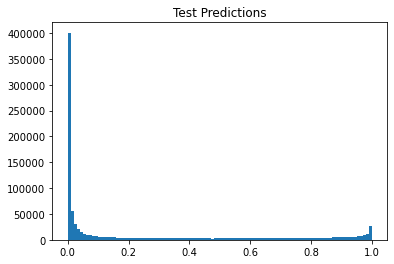

In [26]:
if DO_SUBMIT:
    # WRITE SUBMISSION FILE
#     test_preds = np.concatenate(test_preds)
    test = cudf.DataFrame(index=customers,data={'prediction':test_preds[0]})
    sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
#     sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
#     sub = sub.set_index('customer_ID_hash')
    sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
    sub = sub.reset_index(drop=True)


    # DISPLAY PREDICTIONS
    sub.to_csv(f'../sub/submission_xgb.csv',index=False)
    print('Submission file shape is', sub.shape )
    sub.head()

    # PLOT PREDICTIONS
    plt.hist(sub.prediction, bins=100)
    plt.title('Test Predictions')
    plt.show()